Final Project : Cells classification 


In [103]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn


from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.models import MobileNet_V2_Weights, ResNet50_Weights, VGG16_Weights
from torch import device
from torchvision import transforms, datasets
import optuna
import torch.optim as optim

from collections import Counter


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

Number of images for class SW620: 731
Number of images for class SW480: 958
Number of images for class Monocytes: 53
Number of images for class PBMC: 195
Number of images for class Granulocytes: 142

Data Preprocessing

In [49]:
# Define the transforms for training, validation, and testing datasets
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5], std=[0.5]),
        transforms.Grayscale(num_output_channels=1),]) 

# Load datasets from the folders using ImageFolder
data_dir = r'C:\Users\edendotan\PycharmProjects\DL_course_project\Data images'

full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Function to count the number of images per class
def print_class_distribution(dataset, class_names):
    all_labels = [label for _, label in dataset]

    label_counts = Counter(all_labels)

    for label, count in label_counts.items():
        print(f"Class '{class_names[label]}' has {count} images.")


train_dataset = datasets.ImageFolder(root=f'{data_dir}/train', transform=transform)
val_dataset = datasets.ImageFolder(root=f'{data_dir}/val', transform=transform)
test_dataset = datasets.ImageFolder(root=f'{data_dir}/test', transform=transform)

# Create DataLoaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
# Print the number of images in each set
print(f'Number of images in training set: {len(train_dataset)}')
print(f'Number of images in validation set: {len(val_dataset)}')
print(f'Number of images in test set: {len(test_dataset)}')


Number of images in training set: 1453
Number of images in validation set: 415
Number of images in test set: 211


calculate and print class distribution from a DataLoader

In [56]:
def print_class_distribution_from_dataloader(dataloader, class_names, dataset_name):

    all_labels = []

    # Iterate over the DataLoader and collect all labels
    for _, labels in dataloader:
        all_labels.extend(labels.tolist())  # Collect all labels

    label_counts = Counter(all_labels)

    # Print the distribution of each class
    print(f"\nClass distribution in {dataset_name} dataset:")
    for label, count in label_counts.items():
        print(f"Class '{class_names[label]}' has {count} images.")

print_class_distribution_from_dataloader(train_loader, class_names, "Training")
print_class_distribution_from_dataloader(val_loader, class_names, "Validation")
print_class_distribution_from_dataloader(test_loader, class_names, "Test")



Class distribution in Training dataset:
Class 'SW480' has 670 images.
Class 'SW620' has 511 images.
Class 'PBMC' has 136 images.
Class 'Granulocytes' has 99 images.
Class 'Monocytes' has 37 images.

Class distribution in Validation dataset:
Class 'Granulocytes' has 28 images.
Class 'Monocytes' has 10 images.
Class 'PBMC' has 39 images.
Class 'SW480' has 192 images.
Class 'SW620' has 146 images.

Class distribution in Test dataset:
Class 'Granulocytes' has 15 images.
Class 'Monocytes' has 6 images.
Class 'PBMC' has 20 images.
Class 'SW480' has 96 images.
Class 'SW620' has 74 images.


First iteration - run on 3 models

In [90]:
model_names = ['mobilenet_v2', 'resnet50', 'vgg16']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models_dict = {
    'mobilenet_v2': models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT),
    'resnet50': models.resnet50(weights=ResNet50_Weights.DEFAULT),
    'vgg16': models.vgg16(weights=VGG16_Weights.DEFAULT)
}

num_classes = len(class_names)

for model_name, model in models_dict.items():
    if model_name == 'mobilenet_v2':
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)
        model.features[0][0] = torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)  # Modify input layer
    elif model_name == 'resnet50':
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
        model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)  # Modify input layer
    elif model_name == 'vgg16':
        model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, num_classes)
        model.features[0] = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))  # Modify input layer

    model.to(device)


In [63]:
def train_model(model, train_loader, val_loader, num_epochs, weights,lr):
    criterion = torch.nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(model.parameters(), lr)
    
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Calculate average loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct / total
        
        history['train_loss'].append(epoch_loss)
        history['train_accuracy'].append(epoch_accuracy)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_accuracy = val_correct / val_total
        
        history['val_loss'].append(epoch_val_loss)
        history['val_accuracy'].append(epoch_val_accuracy)
        
        # Print epoch metrics
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, "
              f"Train Accuracy: {epoch_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, "
              f"Val Accuracy: {epoch_val_accuracy:.4f}")
        
    
    print('Finished Training')
    return model, history

def evaluate_model(model, test_loader):
    model.to(device)  
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []
    
    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)  
            labels = labels.to(device) 
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    end_time = time.time()
    processing_time = end_time - start_time
    
    # Convert lists to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # Compute metrics with zero_division parameter
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return accuracy, precision, recall, f1, conf_matrix, processing_time

In [101]:
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()
    
class_names = ['SW620', 'SW480','Monocytes','PBMC', 'Granulocytes']
class_names.reverse()

def plot_training_history(history, model_name):
    plt.figure(figsize=(14, 6))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

Epoch 1/10, Train Loss: 0.1841, Train Accuracy: 0.8796, Val Loss: 0.3432, Val Accuracy: 0.8651
Epoch 2/10, Train Loss: 0.1207, Train Accuracy: 0.9195, Val Loss: 0.3791, Val Accuracy: 0.8578
Epoch 3/10, Train Loss: 0.0983, Train Accuracy: 0.9222, Val Loss: 0.2461, Val Accuracy: 0.8771
Epoch 4/10, Train Loss: 0.0756, Train Accuracy: 0.9312, Val Loss: 0.3502, Val Accuracy: 0.8940
Epoch 5/10, Train Loss: 0.0599, Train Accuracy: 0.9573, Val Loss: 0.1910, Val Accuracy: 0.9229
Epoch 6/10, Train Loss: 0.0786, Train Accuracy: 0.9422, Val Loss: 0.3563, Val Accuracy: 0.9060
Epoch 7/10, Train Loss: 0.1053, Train Accuracy: 0.9264, Val Loss: 0.5627, Val Accuracy: 0.8602
Epoch 8/10, Train Loss: 0.0630, Train Accuracy: 0.9429, Val Loss: 0.3503, Val Accuracy: 0.8675
Epoch 9/10, Train Loss: 0.0471, Train Accuracy: 0.9580, Val Loss: 0.5070, Val Accuracy: 0.8578
Epoch 10/10, Train Loss: 0.0536, Train Accuracy: 0.9587, Val Loss: 0.2736, Val Accuracy: 0.9084
Finished Training
Model: mobilenet_v2
Final Train

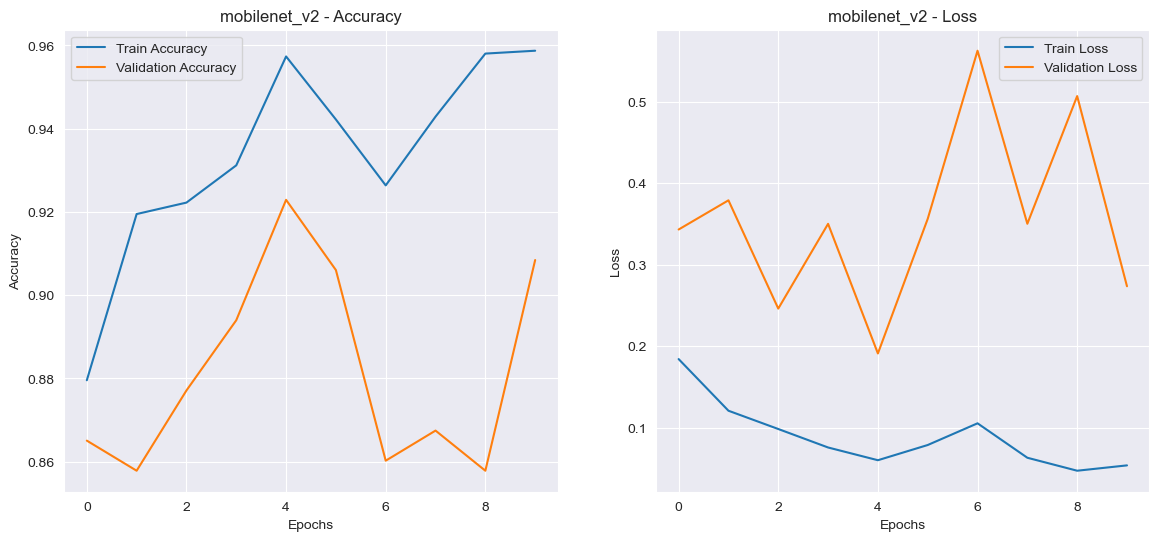

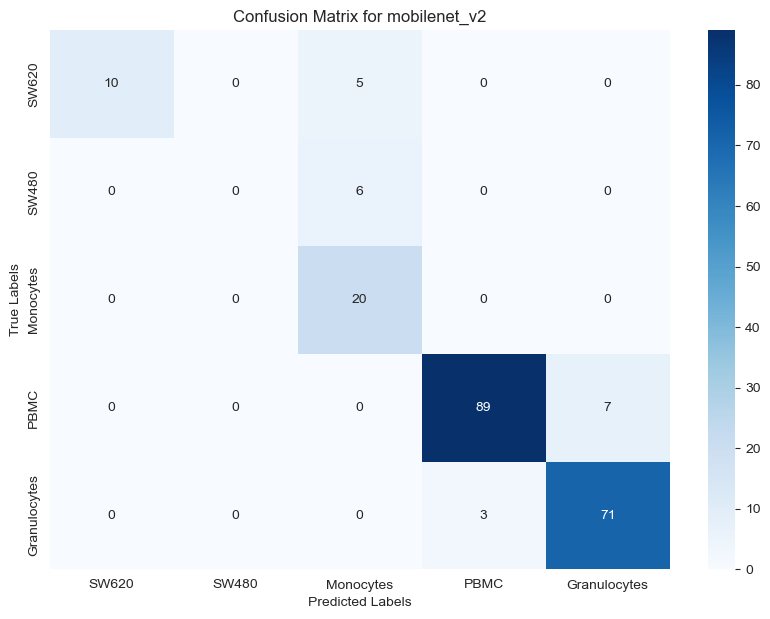

Processing Time: 4.31 seconds
Epoch 1/10, Train Loss: 0.3772, Train Accuracy: 0.8011, Val Loss: 0.7412, Val Accuracy: 0.6988
Epoch 2/10, Train Loss: 0.2113, Train Accuracy: 0.8617, Val Loss: 0.5159, Val Accuracy: 0.8217
Epoch 3/10, Train Loss: 0.1743, Train Accuracy: 0.8672, Val Loss: 0.3060, Val Accuracy: 0.8530
Epoch 4/10, Train Loss: 0.1514, Train Accuracy: 0.8809, Val Loss: 0.5706, Val Accuracy: 0.8000
Epoch 5/10, Train Loss: 0.1322, Train Accuracy: 0.8913, Val Loss: 0.4922, Val Accuracy: 0.8410
Epoch 6/10, Train Loss: 0.1315, Train Accuracy: 0.9098, Val Loss: 0.5631, Val Accuracy: 0.8313
Epoch 7/10, Train Loss: 0.1459, Train Accuracy: 0.8906, Val Loss: 0.3428, Val Accuracy: 0.8434
Epoch 8/10, Train Loss: 0.1230, Train Accuracy: 0.9105, Val Loss: 0.3932, Val Accuracy: 0.8410
Epoch 9/10, Train Loss: 0.1244, Train Accuracy: 0.9181, Val Loss: 0.6239, Val Accuracy: 0.8000
Epoch 10/10, Train Loss: 0.0789, Train Accuracy: 0.9367, Val Loss: 0.4792, Val Accuracy: 0.8627
Finished Training
M

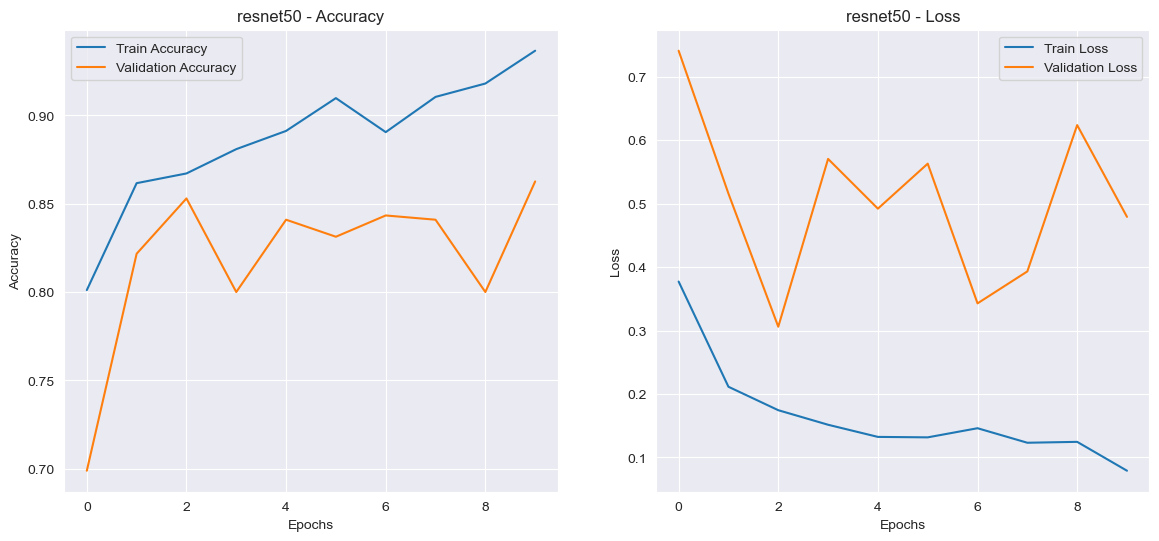

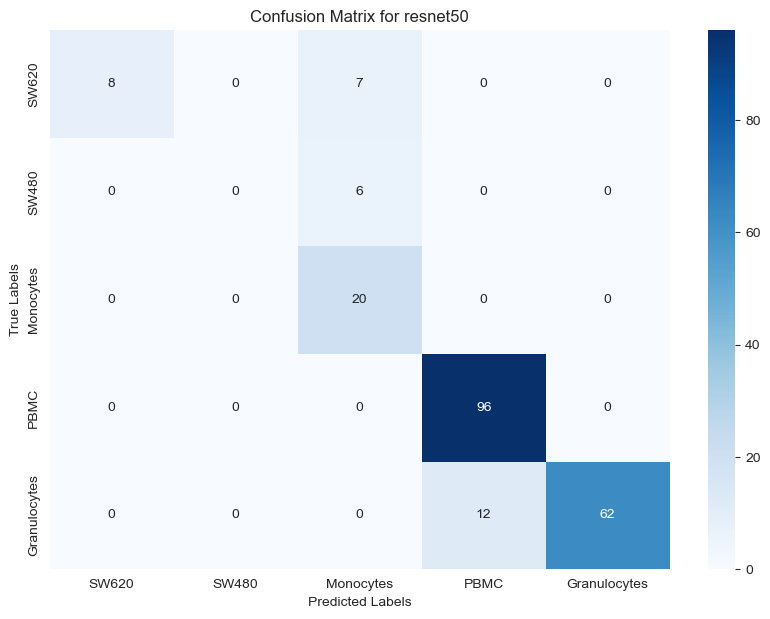

Processing Time: 10.83 seconds
Epoch 1/10, Train Loss: 1.4004, Train Accuracy: 0.4343, Val Loss: 0.8454, Val Accuracy: 0.7422
Epoch 2/10, Train Loss: 0.6528, Train Accuracy: 0.6655, Val Loss: 0.7240, Val Accuracy: 0.6819
Epoch 3/10, Train Loss: 0.4435, Train Accuracy: 0.7577, Val Loss: 0.4653, Val Accuracy: 0.8193
Epoch 4/10, Train Loss: 0.4119, Train Accuracy: 0.7866, Val Loss: 0.4719, Val Accuracy: 0.8072
Epoch 5/10, Train Loss: 0.3351, Train Accuracy: 0.8059, Val Loss: 0.4694, Val Accuracy: 0.8241
Epoch 6/10, Train Loss: 0.3031, Train Accuracy: 0.8259, Val Loss: 0.5904, Val Accuracy: 0.8000
Epoch 7/10, Train Loss: 0.3091, Train Accuracy: 0.8217, Val Loss: 0.3916, Val Accuracy: 0.8361
Epoch 8/10, Train Loss: 0.2913, Train Accuracy: 0.8348, Val Loss: 0.4099, Val Accuracy: 0.8434
Epoch 9/10, Train Loss: 0.7047, Train Accuracy: 0.7220, Val Loss: 0.9483, Val Accuracy: 0.6434
Epoch 10/10, Train Loss: 1.8112, Train Accuracy: 0.5664, Val Loss: 0.8218, Val Accuracy: 0.6843
Finished Training


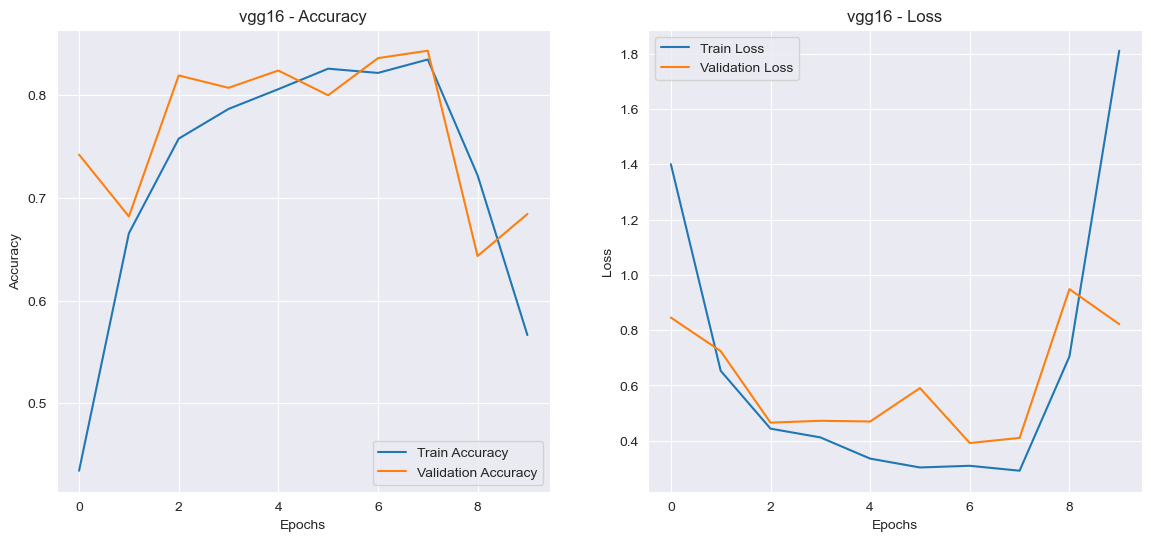

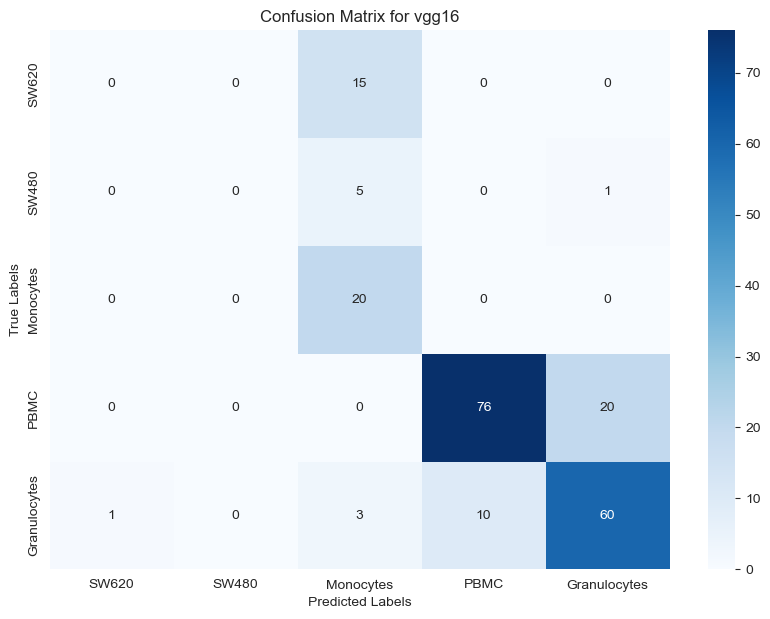

Processing Time: 23.04 seconds


In [65]:
for model_name in model_names:
    model = models_dict[model_name]
    weights = torch.tensor([1/731, 1/958, 1/53, 1/195, 1/142], dtype=torch.float32)
    # Train the model
    trained_model, history= train_model(model, train_loader, val_loader, num_epochs=10,weights=weights,lr=0.001)
    
    # Evaluate the model
    accuracy, precision, recall, f1, conf_matrix, processing_time = evaluate_model(trained_model, test_loader)
    
    print(f"Model: {model_name}")
    print(f"Final Training Loss: {history['train_loss'][-1]:.4f}")
    print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    plot_training_history(history, model_name)
    plot_confusion_matrix(conf_matrix, class_names, title=f'Confusion Matrix for {model_name}')
    print(f"Processing Time: {processing_time:.2f} seconds")


Second iteration - Hyperparameter tuning

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def objective(trial):
    model_name = trial.suggest_categorical('model_name', ['mobilenet_v2', 'resnet50', 'vgg16'])
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    
    # Adjust the DataLoader to use the suggested batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Get the number of classes
    num_classes = len(class_names)

    if model_name == 'mobilenet_v2':
        model = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)
        model.features[0][0] = torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    elif model_name == 'resnet50':
        model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
        model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    elif model_name == 'vgg16':
        model = models.vgg16(weights=VGG16_Weights.DEFAULT)
        model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, num_classes)
        model.features[0] = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    model.to(device)

    # Define the loss function and optimizer
    weights = torch.tensor([1/731, 1/958, 1/53, 1/195, 1/142], dtype=torch.float32, device=device)
    criterion = torch.nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    num_epochs = 5
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        epoch_val_accuracy = val_correct / val_total
        
        trial.report(epoch_val_accuracy, epoch)
        
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return epoch_val_accuracy 

study_name = "hyperparameter_study_3_models" 
study = optuna.create_study(direction='maximize', study_name=study_name)
study.optimize(objective, n_trials=40)

# Print the best hyperparameters found
print("Best hyperparameters:", study.best_params)

# Best trial for your model
print("Best trial value (accuracy):", study.best_value)

# You can also retrieve the best trial and its corresponding hyperparameters:
best_trial = study.best_trial
print("Best trial hyperparameters:", best_trial.params)

[I 2024-09-18 08:07:33,375] A new study created in memory with name: hyperparameter_study_3_models
[I 2024-09-18 08:28:38,656] Trial 0 finished with value: 0.09879518072289156 and parameters: {'model_name': 'resnet50', 'lr': 0.007671601399325793, 'weight_decay': 0.0001813510194786719, 'batch_size': 16}. Best is trial 0 with value: 0.09879518072289156.
[I 2024-09-18 08:50:16,887] Trial 1 finished with value: 0.8578313253012049 and parameters: {'model_name': 'resnet50', 'lr': 2.6851385154879277e-05, 'weight_decay': 2.8938914702964346e-06, 'batch_size': 32}. Best is trial 1 with value: 0.8578313253012049.
[I 2024-09-18 09:11:15,162] Trial 2 finished with value: 0.10120481927710843 and parameters: {'model_name': 'resnet50', 'lr': 0.003681557998917005, 'weight_decay': 6.930428180641384e-06, 'batch_size': 16}. Best is trial 1 with value: 0.8578313253012049.
[I 2024-09-18 09:33:01,457] Trial 3 finished with value: 0.619277108433735 and parameters: {'model_name': 'resnet50', 'lr': 0.0002208248

Best hyperparameters: {'model_name': 'vgg16', 'lr': 2.2492038172386544e-05, 'weight_decay': 8.228835419153499e-06, 'batch_size': 32}
Best trial value (accuracy): 0.9301204819277108
Best trial hyperparameters: {'model_name': 'vgg16', 'lr': 2.2492038172386544e-05, 'weight_decay': 8.228835419153499e-06, 'batch_size': 32}


Third iteration - train models on augmented data

In [79]:
weights = torch.tensor([1/731, 1/958, 1/212, 1/780, 1/568], dtype=torch.float32)
best_lr = 2.2492038172386544e-05
best_batch_size = 32

# Augmented data directory
data_dir = r'C:\Users\edendotan\PycharmProjects\DL_course_project\session number 3\Augmented data images'

train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Load datasets
train_aug_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_aug_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_aug_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Define the DataLoader
train_loader = torch.utils.data.DataLoader(train_aug_dataset, batch_size=best_batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_aug_dataset, batch_size=best_batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_aug_dataset, batch_size=best_batch_size, shuffle=False)

In [87]:
def plot_and_save_roc_curve(model, test_loader, class_names, save_path):
    all_labels = []
    all_probs = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy())
    
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(np.array(all_labels) == i, np.array(all_probs)[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f}) for {class_name}')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')
    plt.legend(loc='lower right')
    plt.savefig(save_path)
    plt.show()

Training mobilenet_v2...
Epoch 1/20, Train Loss: 1.1599, Train Accuracy: 0.5735, Val Loss: 1.3221, Val Accuracy: 0.6000
Epoch 2/20, Train Loss: 0.7412, Train Accuracy: 0.6747, Val Loss: 0.8269, Val Accuracy: 0.7169
Epoch 3/20, Train Loss: 0.5607, Train Accuracy: 0.7082, Val Loss: 0.6157, Val Accuracy: 0.7815
Epoch 4/20, Train Loss: 0.4213, Train Accuracy: 0.7861, Val Loss: 0.4470, Val Accuracy: 0.8569
Epoch 5/20, Train Loss: 0.3124, Train Accuracy: 0.8490, Val Loss: 0.3647, Val Accuracy: 0.8600
Epoch 6/20, Train Loss: 0.2430, Train Accuracy: 0.8728, Val Loss: 0.3039, Val Accuracy: 0.8738
Epoch 7/20, Train Loss: 0.1938, Train Accuracy: 0.8930, Val Loss: 0.2859, Val Accuracy: 0.8800
Epoch 8/20, Train Loss: 0.1635, Train Accuracy: 0.9181, Val Loss: 0.2364, Val Accuracy: 0.9046
Epoch 9/20, Train Loss: 0.1340, Train Accuracy: 0.9406, Val Loss: 0.2090, Val Accuracy: 0.9354
Epoch 10/20, Train Loss: 0.1181, Train Accuracy: 0.9507, Val Loss: 0.2298, Val Accuracy: 0.9185
Epoch 11/20, Train Loss:

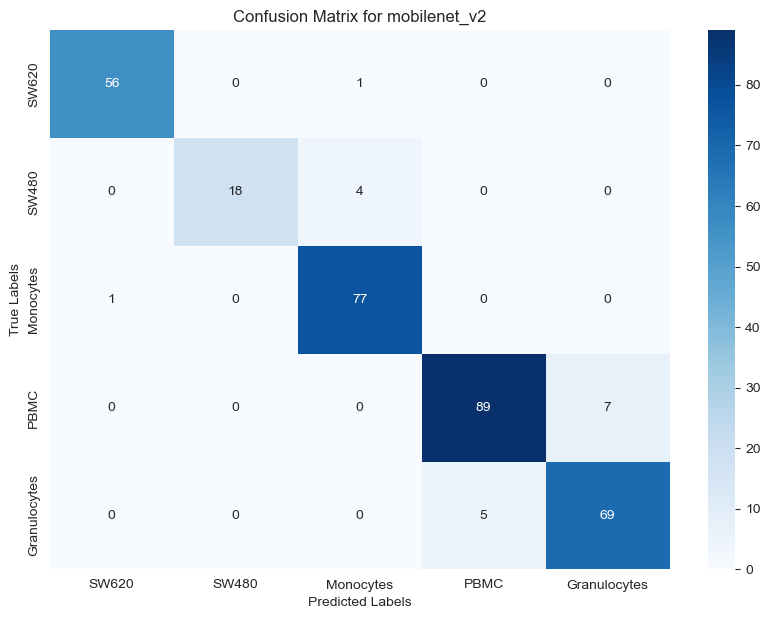

Confusion matrix saved: C:\Users\edendotan\PycharmProjects\DL_cours_project\results\mobilenet_v2_confusion_matrix.png


<Figure size 640x480 with 0 Axes>

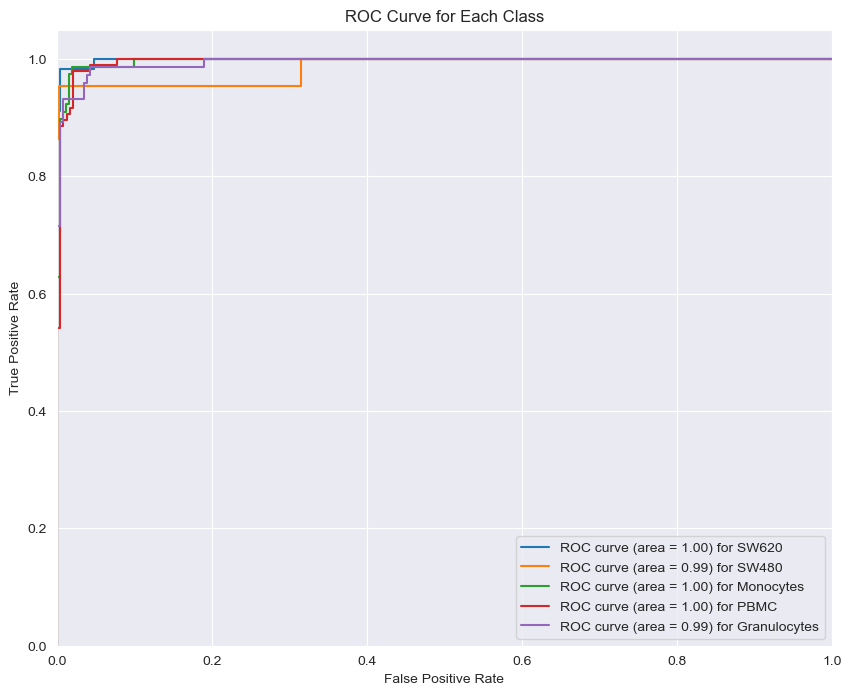

ROC curve saved: C:\Users\edendotan\PycharmProjects\DL_cours_project\results\mobilenet_v2_roc_curve.png
Training resnet50...
Epoch 1/20, Train Loss: 0.9362, Train Accuracy: 0.5783, Val Loss: 1.1554, Val Accuracy: 0.5800
Epoch 2/20, Train Loss: 0.4424, Train Accuracy: 0.7452, Val Loss: 0.4051, Val Accuracy: 0.8492
Epoch 3/20, Train Loss: 0.2099, Train Accuracy: 0.8856, Val Loss: 0.2666, Val Accuracy: 0.8769
Epoch 4/20, Train Loss: 0.1165, Train Accuracy: 0.9441, Val Loss: 0.2036, Val Accuracy: 0.9292
Epoch 5/20, Train Loss: 0.0714, Train Accuracy: 0.9776, Val Loss: 0.2375, Val Accuracy: 0.9169
Epoch 6/20, Train Loss: 0.0341, Train Accuracy: 0.9903, Val Loss: 0.1893, Val Accuracy: 0.9323
Epoch 7/20, Train Loss: 0.0303, Train Accuracy: 0.9925, Val Loss: 0.2385, Val Accuracy: 0.9292
Epoch 8/20, Train Loss: 0.0425, Train Accuracy: 0.9859, Val Loss: 0.2060, Val Accuracy: 0.9354
Epoch 9/20, Train Loss: 0.0189, Train Accuracy: 0.9947, Val Loss: 0.3217, Val Accuracy: 0.8969
Epoch 10/20, Train L

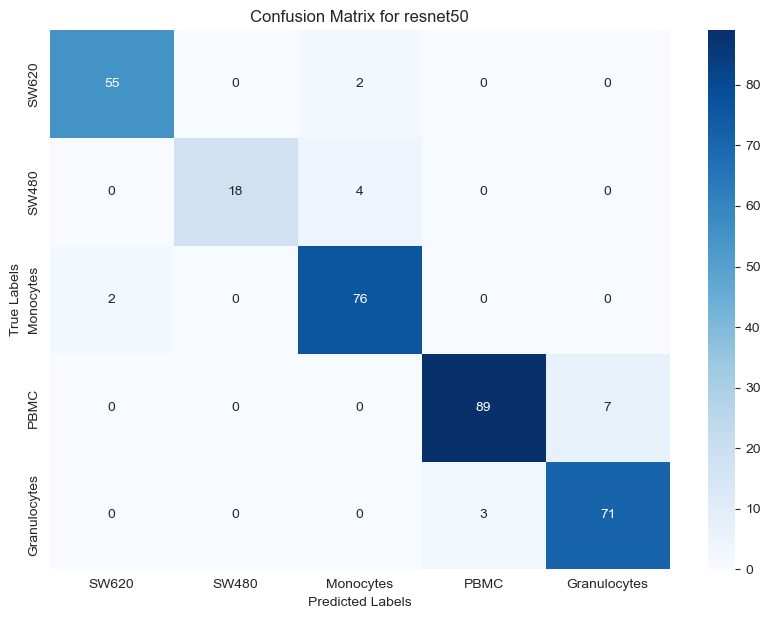

Confusion matrix saved: C:\Users\edendotan\PycharmProjects\DL_cours_project\results\resnet50_confusion_matrix.png


<Figure size 640x480 with 0 Axes>

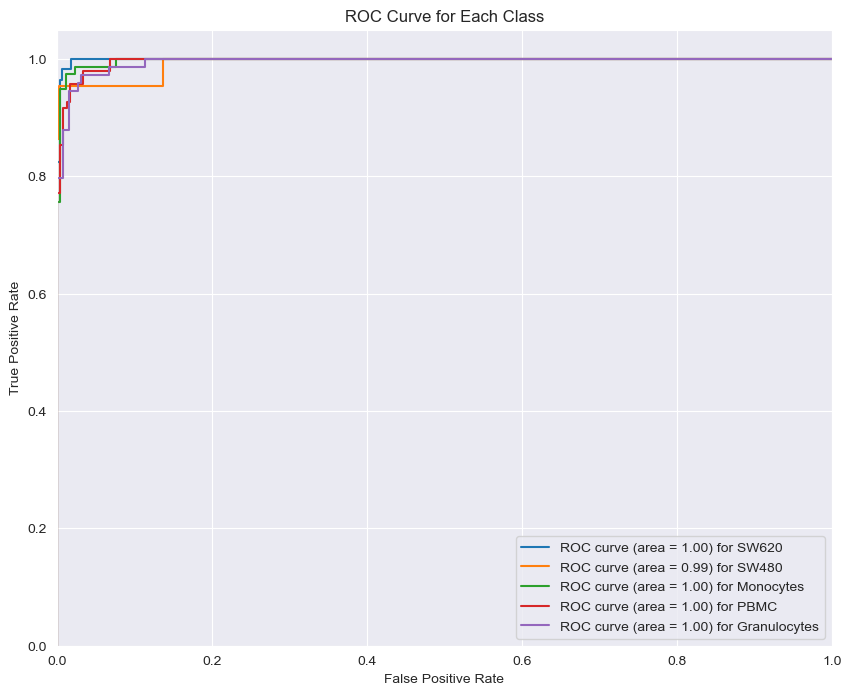

ROC curve saved: C:\Users\edendotan\PycharmProjects\DL_cours_project\results\resnet50_roc_curve.png
Training vgg16...
Epoch 1/20, Train Loss: 0.6205, Train Accuracy: 0.6835, Val Loss: 0.3452, Val Accuracy: 0.8508
Epoch 2/20, Train Loss: 0.2093, Train Accuracy: 0.8908, Val Loss: 0.2264, Val Accuracy: 0.9185
Epoch 3/20, Train Loss: 0.1428, Train Accuracy: 0.9375, Val Loss: 0.2185, Val Accuracy: 0.9308
Epoch 4/20, Train Loss: 0.1125, Train Accuracy: 0.9415, Val Loss: 0.1471, Val Accuracy: 0.9554
Epoch 5/20, Train Loss: 0.0799, Train Accuracy: 0.9608, Val Loss: 0.1665, Val Accuracy: 0.9462
Epoch 6/20, Train Loss: 0.0619, Train Accuracy: 0.9705, Val Loss: 0.1461, Val Accuracy: 0.9492
Epoch 7/20, Train Loss: 0.0452, Train Accuracy: 0.9784, Val Loss: 0.2619, Val Accuracy: 0.9308
Epoch 8/20, Train Loss: 0.0487, Train Accuracy: 0.9754, Val Loss: 0.2873, Val Accuracy: 0.9385
Epoch 9/20, Train Loss: 0.0355, Train Accuracy: 0.9815, Val Loss: 0.1860, Val Accuracy: 0.9554
Epoch 10/20, Train Loss: 0.

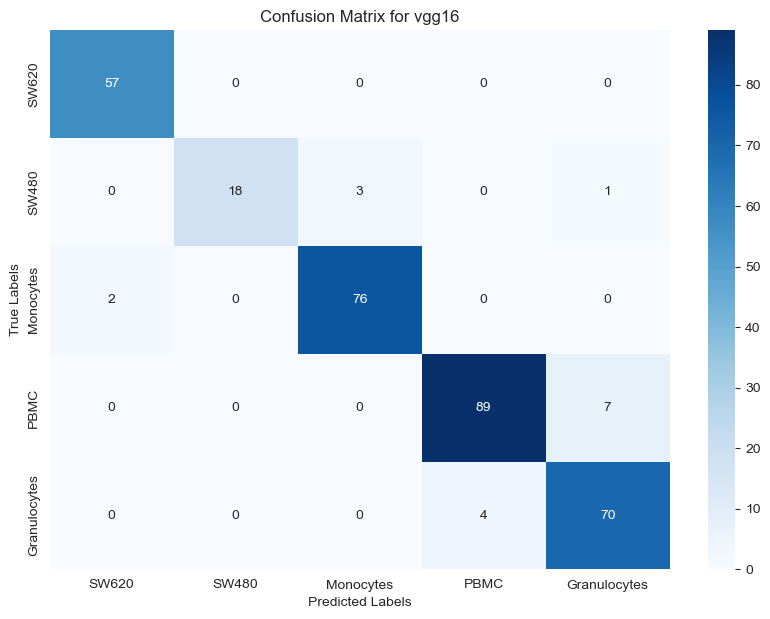

Confusion matrix saved: C:\Users\edendotan\PycharmProjects\DL_cours_project\results\vgg16_confusion_matrix.png


<Figure size 640x480 with 0 Axes>

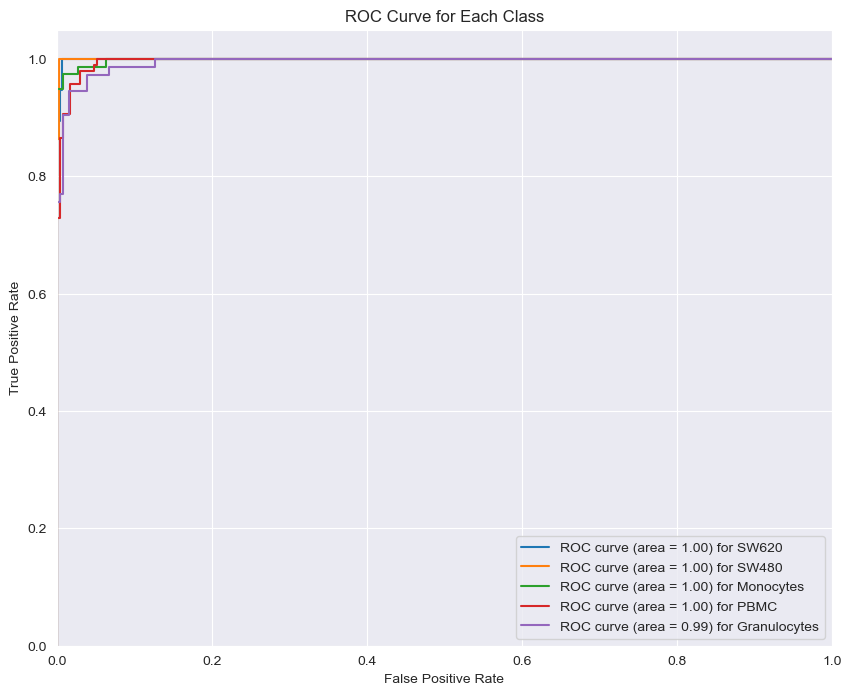

ROC curve saved: C:\Users\edendotan\PycharmProjects\DL_cours_project\results\vgg16_roc_curve.png
Evaluation metrics saved to C:\Users\edendotan\PycharmProjects\DL_cours_project\results\best_models_evaluation_metrics.xlsx


In [91]:
save_dir = r'C:\Users\edendotan\PycharmProjects\DL_course_project\results'

metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Processing Time'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for model_name in model_names:
    print(f"Training {model_name}...")

    model = models_dict[model_name].to(device)

    trained_model, history = train_model(model, train_loader, val_loader, num_epochs=20, weights=weights, lr=best_lr)

    # Save the trained model
    model_save_path = os.path.join(save_dir, f'{model_name}_best_model.pth')
    torch.save(trained_model.state_dict(), model_save_path)
    print(f"Model saved: {model_save_path}")

    # Evaluate the model
    accuracy, precision, recall, f1, conf_matrix, processing_time = evaluate_model(trained_model, test_loader)

    metrics_df.loc[len(metrics_df)] = {
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Processing Time': processing_time }

    # Save the confusion matrix
    confusion_matrix_save_path = os.path.join(save_dir, f'{model_name}_confusion_matrix.png')
    plot_confusion_matrix(conf_matrix, class_names, title=f'Confusion Matrix for {model_name}')
    plt.savefig(confusion_matrix_save_path)
    print(f"Confusion matrix saved: {confusion_matrix_save_path}")

    # Save the ROC curve
    roc_save_path = os.path.join(save_dir, f'{model_name}_roc_curve.png')
    plot_and_save_roc_curve(trained_model, test_loader, class_names, roc_save_path)
    print(f"ROC curve saved: {roc_save_path}")

# Save the evaluation metrics to an Excel file
metrics_save_path = os.path.join(save_dir, 'best_models_evaluation_metrics.xlsx')
metrics_df.to_excel(metrics_save_path, index=False)
print(f"Evaluation metrics saved to {metrics_save_path}")



Compression between all models - Plot a Dot Graph for Sensitivity vs Processing Time

In [97]:
excel_save_path_1 = r'C:\Users\edendotan\PycharmProjects\DL_course_project\results\best_models_evaluation_metrics.xlsx'
metrics_df_1 = pd.read_excel(excel_save_path_1)

excel_save_path_2 = r'C:\Users\edendotan\PycharmProjects\DL_course_project\results\DinoV2_evaluation_metrics.xlsx'
metrics_df_2 = pd.read_excel(excel_save_path_2)

combined_metrics_df = pd.concat([metrics_df_1, metrics_df_2], ignore_index=True)

print(combined_metrics_df)


          Model  Accuracy  Precision    Recall  F1 Score  Processing Time
0  mobilenet_v2  0.944954   0.945938  0.944954  0.944623        10.253225
1      resnet50  0.944954   0.946548  0.944954  0.944725        26.398875
2         vgg16  0.948012   0.949196  0.948012  0.947718        36.719156
3        Dinov2  0.553517   0.464462  0.553517  0.468478        40.005350


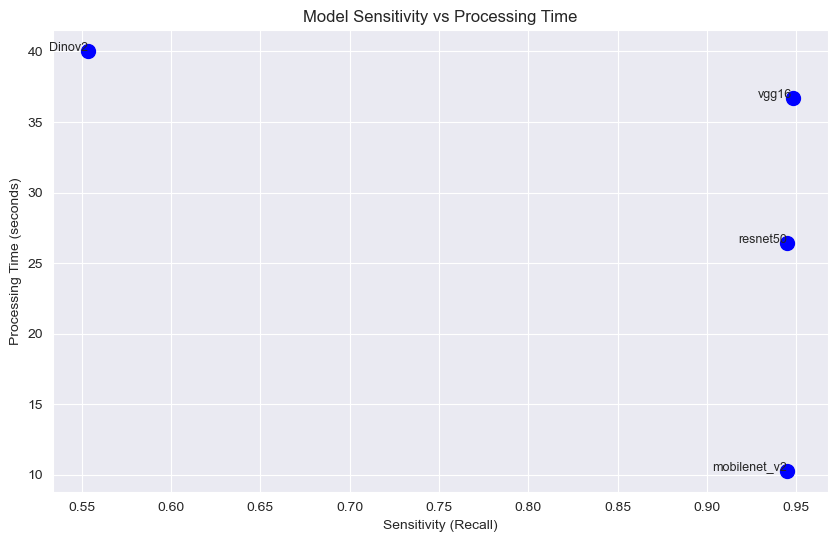

In [98]:

models = combined_metrics_df['Model']
sensitivity = combined_metrics_df['Recall'] 
processing_time = combined_metrics_df['Processing Time']

plt.figure(figsize=(10, 6))
plt.scatter(sensitivity, processing_time, color='b', s=100) 

for i, model in enumerate(models):
    plt.text(sensitivity[i], processing_time[i], model, fontsize=9, ha='right')

plt.xlabel('Sensitivity (Recall)')
plt.ylabel('Processing Time (seconds)')
plt.title('Model Sensitivity vs Processing Time')

plt.grid(True)
plt.show()


In [99]:
plot_save_path = r'C:\Users\edendotan\PycharmProjects\DL_course_project\results\sensitivity_vs_processing_time_combined.png'
plt.savefig(plot_save_path)

<Figure size 640x480 with 0 Axes>

Re-plotting confusion matrix (fix indexes mistake)

In [110]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.mobilenet_v2(weights=None)
model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 5)
# Load the saved model weights
model.load_state_dict(torch.load('C:\\Users\\edendotan\\PycharmProjects\\DL_course_project\\results\\mobilenet_v2_best_model.pth'))
model.to(device)
# Set the model to evaluation mode
model.eval()
accuracy, precision, recall, f1, conf_matrix, processing_time= evaluate_model(model, test_loader)

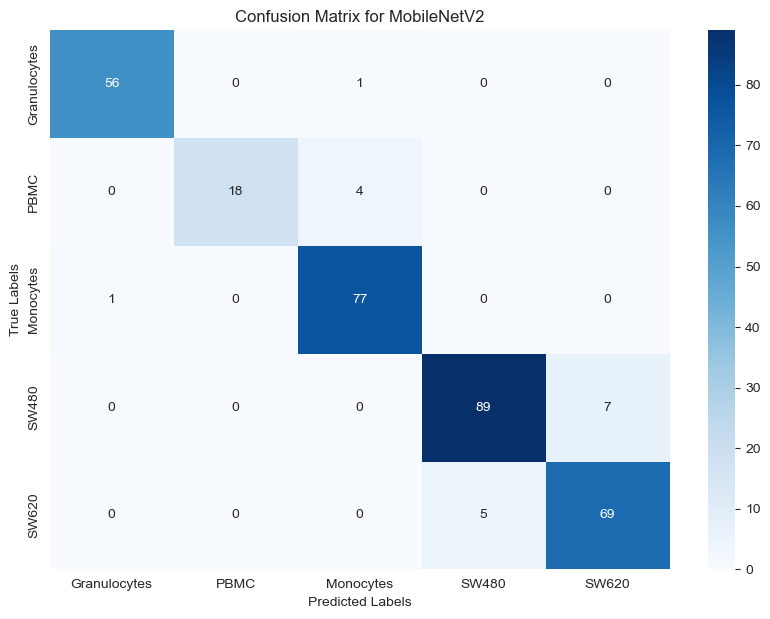

In [112]:
plot_confusion_matrix(conf_matrix, class_names, title=f'Confusion Matrix for MobileNetV2')


In [114]:
model = models.resnet50(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# Load the saved model weights
model.load_state_dict(torch.load('C:\\Users\\edendotan\\PycharmProjects\\DL_course_project\\results\\resnet50_best_model.pth'))
model.to(device)
# Set the model to evaluation mode
model.eval()
accuracy, precision, recall, f1, conf_matrix, processing_time= evaluate_model(model, test_loader)

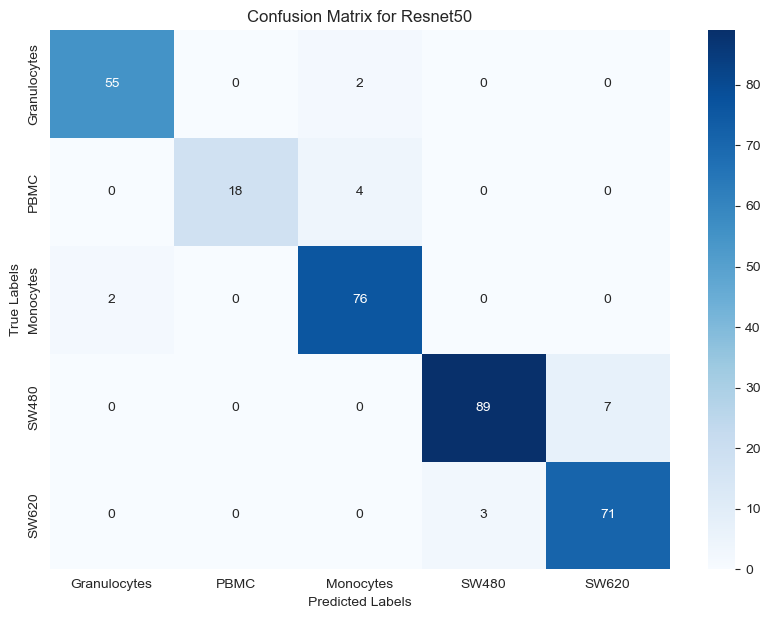

In [115]:
plot_confusion_matrix(conf_matrix, class_names, title=f'Confusion Matrix for Resnet50')

In [118]:
model = models.vgg16(weights=None)
model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, num_classes)
model.features[0] = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 
model.load_state_dict(torch.load('C:\\Users\\edendotan\\PycharmProjects\\DL_course_project\\results\\vgg16_best_model.pth'))
model.to(device)
model.eval()
accuracy, precision, recall, f1, conf_matrix, processing_time= evaluate_model(model, test_loader)


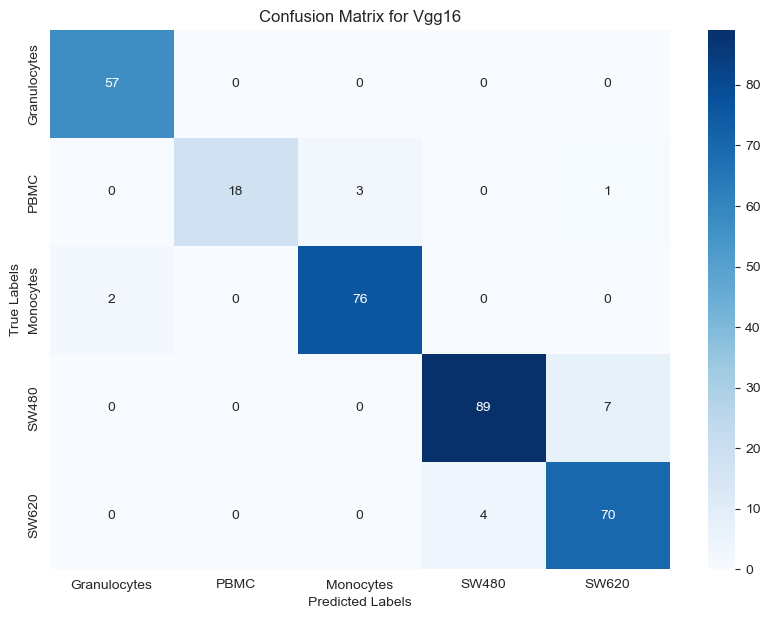

In [119]:
plot_confusion_matrix(conf_matrix, class_names, title=f'Confusion Matrix for Vgg16')
